# Training

In deze notebook gaan we verschillende pre-trained modellen finetunen op onze gegenereerde data. We hebben deze modellen gekozen op verschillende eisen. Waar zijn ze op getrained? hHoe groot zijn de modellen? Zijn ze opensource? enz..

In [3]:
# import os
# import json
# import glob
# from collections import defaultdict
# from transformers import pipeline, AutoTokenizer
# from tqdm import tqdm
# import torch

# # === CONFIG ===
# DATA_PATH = "../data/chat_logs"
# OUTPUT_FILE = "samengevoegd_met_samenvattingen_local.jsonl"
# MODEL_NAME = "philschmid/bart-large-cnn-samsum"

# # === SAMENVATTINGSMODEL EN TOKENIZER LADEN ===
# device = 0 if torch.cuda.is_available() else -1
# print(f"Device set to use: {'cuda' if device == 0 else 'cpu'}")

# summarizer = pipeline("summarization", model=MODEL_NAME, tokenizer=MODEL_NAME, device=device)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# MAX_INPUT_LENGTH = tokenizer.model_max_length

# def split_text_by_tokens(text, tokenizer, max_input_tokens):
#     """
#     Splitst een lange tekst in stukken die elk maximaal max_input_tokens tokens bevatten.
#     """
#     tokens = tokenizer.encode(text, add_special_tokens=False)
#     chunks = []
#     for i in range(0, len(tokens), max_input_tokens):
#         chunk_tokens = tokens[i:i+max_input_tokens]
#         chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
#         chunks.append(chunk_text)
#     return chunks

# # === BESTANDEN VERWERKEN ===
# all_chat_data = []

# for filepath in glob.glob(os.path.join(DATA_PATH, "*.json")):
#     with open(filepath, "r", encoding="utf-8") as f:
#         data = json.load(f)
#         print(len(data), "items gevonden in", filepath)
#     topics = defaultdict(list)
#     for item in data:
#         topics[item["topic_id"]].append(item["text"])

#     for topic_id, messages in topics.items():
#         combined_text = " ".join(messages)
#         if len(combined_text.strip()) < 50:
#             continue

#         try:
#             text_chunks = split_text_by_tokens(combined_text, tokenizer, MAX_INPUT_LENGTH - 5)
#             summaries = []

#             for chunk in text_chunks:
#                 if not chunk.strip():
#                     continue
#                 summary_output = summarizer(
#                     chunk,
#                     max_length=100,
#                     min_length=30,
#                     do_sample=False,
#                 )
#                 summaries.append(summary_output[0]["summary_text"])

#             full_summary = " ".join(summaries)
#             if not full_summary.strip():
#                 full_summary = "No summary generated."

#         except Exception as e:
#             print(f"Error summarizing topic_id {topic_id}: {e}")
#             full_summary = "Summary not available due to error."

#         all_chat_data.append({
#             "topic_id": topic_id,
#             "chat": combined_text,
#             "summary": full_summary
#         })

# # === OPSLAAN ALS JSONL ===
# with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
#     for entry in all_chat_data:
#         json.dump(entry, f, ensure_ascii=False)
#         f.write("\n")

# print(f"Dataset opgeslagen als {OUTPUT_FILE} met {len(all_chat_data)} items.")

**Uitleg:**  
Deze code:
- Laadt een BART-samenvattingsmodel (`bart-large-cnn-samsum`) en bijbehorende tokenizer.
- Verwerkt JSON-chatdata per `topic_id`, combineert tekst tot één document per onderwerp.
- Splits lange documenten op in chunks die passen in het model (minder dan `MAX_INPUT_LENGTH` tokens).
- Genereert per chunk een samenvatting en combineert deze.
- Slaat alles op als `.jsonl`-bestand waarin elke regel een samenvatting bevat.



In [4]:
from datasets import load_dataset, Dataset
import json
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import torch
from collections import defaultdict

# Laad je jsonl-bestand in als een lijst van dicts
with open("samengevoegd_met_samenvattingen_local.jsonl", "r", encoding="utf-8") as f:
    chat_data = [json.loads(line) for line in f]

# Maak een Huggingface Dataset
dataset = Dataset.from_list(chat_data)
# Tokenizer en model laden
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    inputs = tokenizer(example["chat"], max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=False)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)


c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/10 [00:00<?, ? examples/s]c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 10/10 [00:00<00:00, 18.42 examples/s]


**Uitleg:**  
Deze cel:
- Laadt het JSONL-bestand met gegenereerde samenvattingen.
- Zet het om naar een Hugging Face `Dataset`.
- Laadt `facebook/bart-base` model/tokenizer.
- Tokeniseert de 'chat' als input en de 'summary' als target.
- Gebruikt padding en truncation om input/output op vaste lengte te brengen.


## Bart

In [ ]:
from datasets import load_dataset, Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import torch
from collections import defaultdict
import json



# Tokenizer en model laden
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    inputs = tokenizer(example["chat"], max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=False)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training parameters
training_args = TrainingArguments(
    output_dir="./bartsummarizer",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    save_steps=500,
    logging_dir="./logs",
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=2,
    report_to=[],

)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training starten
trainer.train()
model.save_pretrained("./bartsummarizer")
tokenizer.save_pretrained("./bartsummarizer")


Map: 100%|██████████| 10/10 [00:00<00:00, 17.95 examples/s]
C:\Users\Mark\AppData\Local\Temp\ipykernel_5776\3881543212.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\transformers\modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./bart-summarizer\\tokenizer_config.json',
 './bart-summarizer\\special_tokens_map.json',
 './bart-summarizer\\vocab.json',
 './bart-summarizer\\merges.txt',
 './bart-summarizer\\added_tokens.json')

**Uitleg:**  
Deze cel:
- Herhaalt het tokeniseren van de dataset.
- Stelt de `TrainingArguments` in, o.a.:
  - `batch_size = 4`
  - `epochs = 1`
  - `learning_rate = 2e-5`
- Maakt gebruik van `Trainer` om het model te trainen.
- Slaat het getrainde model en tokenizer op in `./bart-summarizer`.


## T5-Base

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq


# Model en tokenizer laden
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    input_text = "summarize: " + example["chat"]
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training parameters
training_args = TrainingArguments(
    output_dir="./t5summarizer",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to=[],

)

# Trainer opzetten
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training starten
trainer.train()

# Model opslaan
model.save_pretrained("./t5summarizer")
tokenizer.save_pretrained("./t5summarizer")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Map: 100%|██████████| 10/10 [00:00<00:00, 34.72 examples/s]
C:\Users\Mark\AppData\Local\Temp\ipykernel_5776\4082124666.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


('./t5-summarizer\\tokenizer_config.json',
 './t5-summarizer\\special_tokens_map.json',
 './t5-summarizer\\spiece.model',
 './t5-summarizer\\added_tokens.json')

**Uitleg:**  
Deze cel:
- Herhaalt het tokeniseren van de dataset.
- Stelt de `TrainingArguments` in, o.a.:
  - `batch_size = 4`
  - `epochs = 1`
  - `learning_rate = 2e-5`
- Maakt gebruik van `Trainer` om het model te trainen.
- Slaat het getrainde model en tokenizer op in `./t5-summarizer`.



## T5-Long

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq



# Model en tokenizer laden
model_name = "google/long-t5-tglobal-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    input_text = "summarize: " + example["chat"]
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training parameters
training_args = TrainingArguments(
    output_dir="./longt5summarizer",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,    
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to=[],
    fp16=True,
)

# Trainer opzetten
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training starten
trainer.train()

# Model opslaan
model.save_pretrained("./longt5summarizer")
tokenizer.save_pretrained("./longt5summarizer")


c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mark\.cache\huggingface\hub\models--google--long-t5-tglobal-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using a model of type longt5 to instantiate a model of type t5. Th

Step,Training Loss


('./long-t5-summarizer\\tokenizer_config.json',
 './long-t5-summarizer\\special_tokens_map.json',
 './long-t5-summarizer\\spiece.model',
 './long-t5-summarizer\\added_tokens.json')

**Uitleg:**  
Deze cel:
- Herhaalt het tokeniseren van de dataset.
- Stelt de `TrainingArguments` in, o.a.:
  - `batch_size = 4`
  - `epochs = 1`
  - `learning_rate = 2e-5`
- Maakt gebruik van `Trainer` om het model te trainen.
- Slaat het getrainde model en tokenizer op in `./long-t5-summarizer`.

## T5-Flan

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq


# Model en tokenizer laden
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    input_text = "summarize: " + example["chat"]
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training parameters
training_args = TrainingArguments(
    output_dir="./flant5summarizer",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to=[],
    fp16=True,

)

# Trainer opzetten
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training starten
trainer.train()

# Model opslaan
model.save_pretrained("./flant5summarizer")
tokenizer.save_pretrained("./flant5summarizer")


Map: 100%|██████████| 10/10 [00:00<00:00, 34.35 examples/s]
C:\Users\Mark\AppData\Local\Temp\ipykernel_5776\3768459877.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


('./flan-t5-summarizer\\tokenizer_config.json',
 './flan-t5-summarizer\\special_tokens_map.json',
 './flan-t5-summarizer\\spiece.model',
 './flan-t5-summarizer\\added_tokens.json')

**Uitleg:**  
Deze cel:
- Herhaalt het tokeniseren van de dataset.
- Stelt de `TrainingArguments` in, o.a.:
  - `batch_size = 4`
  - `epochs = 1`
  - `learning_rate = 2e-5`
- Maakt gebruik van `Trainer` om het model te trainen.
- Slaat het getrainde model en tokenizer op in `./flan-t5-summarizer`.



## PEGASUS

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Model en tokenizer laden
model_name = "google/pegasus-xsum"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    input_text = "summarize: " + example["chat"]
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training parameters
training_args = TrainingArguments(
    output_dir="./pegasussummarizer",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to=[],
    fp16=True,

)

# Trainer opzetten
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training starten
trainer.train()

# Model opslaan
model.save_pretrained("./pegasussummarizer")
tokenizer.save_pretrained("./pegasussummarizer")


c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mark\.cache\huggingface\hub\models--google--pegasus-xsum. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of PegasusForConditionalGeneration were not initialized from the mode

Step,Training Loss


c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\transformers\modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./pegasus-summarizer\\tokenizer_config.json',
 './pegasus-summarizer\\special_tokens_map.json',
 './pegasus-summarizer\\spiece.model',
 './pegasus-summarizer\\added_tokens.json')

**Uitleg:**  
Deze cel:
- Herhaalt het tokeniseren van de dataset (indien nog niet gebeurd).
- Stelt de `TrainingArguments` in, o.a.:
  - `batch_size = 4`
  - `epochs = 1`
  - `learning_rate = 2e-5`
- Maakt gebruik van `Trainer` om het model te trainen.
- Slaat het getrainde model en tokenizer op in `./pegasus-summarizer`.


## LED

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


# Model en tokenizer laden
model_name = "allenai/led-base-16384"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Preprocessing-functie
def preprocess_function(example):
    input_text = "summarize: " + example["chat"]
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(example["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training parameters
training_args = TrainingArguments(
    output_dir="./longformersummarizer",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to=[],
    fp16=True,

)

# Trainer opzetten
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training starten
trainer.train()

# Model opslaan
model.save_pretrained("./longformersummarizer")
tokenizer.save_pretrained("./longformersummarizer")


c:\Users\Mark\Documents\School\ADS\datalab5\Datalab-lectoraat\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mark\.cache\huggingface\hub\models--allenai--led-base-16384. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed

Step,Training Loss


('./longformer-summarizer\\tokenizer_config.json',
 './longformer-summarizer\\special_tokens_map.json',
 './longformer-summarizer\\vocab.json',
 './longformer-summarizer\\merges.txt',
 './longformer-summarizer\\added_tokens.json',
 './longformer-summarizer\\tokenizer.json')


**Uitleg:**  
Deze cel:
- Herhaalt het tokeniseren van de dataset (indien nog niet gebeurd).
- Stelt de `TrainingArguments` in, o.a.:
  - `batch_size = 4`
  - `epochs = 1`
  - `learning_rate = 2e-5`
- Maakt gebruik van `Trainer` om het model te trainen.
- Slaat het getrainde model en tokenizer op in `./longformer-summarizer`.



# Evaluatie

In dit deel van de notebook gaan we kijken welke van onze modellen het best presteerd op een kleine evaluatie dataset.

Eerst bereken we de ROUGE scoren op een heel simpel dataset. Daarna kijken we zelf met een iets ingewikkeldere chat welke samenvatting van de best scorende model wij beter vinden.

In [11]:
from datasets import Dataset

test_data = Dataset.from_dict({
    "chat": [
        "Hoi allemaal! Ze willen windmolens bouwen buiten het dorp. Wat vinden jullie? Er zijn zorgen over geluidsoverlast en impact op het landschap.",
        "We hebben een bijeenkomst gepland over het nieuwe buurthuis. Mensen willen weten of er genoeg budget is en hoe de planning eruitziet."
    ],
    "summary": [
        "Er is discussie over de bouw van windmolens buiten het dorp, met zorgen over geluid en landschap.",
        "Er komt een bijeenkomst over het buurthuis, met vragen over budget en planning."
    ]
})


In [12]:
sumary = "Buurtbewoners bespreken het plan voor een nieuw parkeerterrein aan de dorpsrand. Arthur en Koen vinden extra parkeerplaatsen positief, maar Fatima maakt zich zorgen over de nabijheid van het speelveldje. Linda vreest voor het uitzicht vanuit haar woning. Peter meldt dat het een groen terrein wordt met bomen, wat positief ontvangen wordt. Koen wijst erop dat het aantal plekken teruggaat van 60 naar 45 om ruimte te maken voor groen. Fatima en Linda stellen voor een groenstrook aan te leggen tussen het speelveld en het parkeerterrein, voor veiligheid en minder zicht. Linda wil dat de gemeente een visualisatie deelt, en Peter stelt voor mee te denken over de inrichting. Allen zijn het erover eens dat bewoners betrokken moeten worden bij de plannen en gezamenlijk suggesties aan de gemeente moeten doen."


In [16]:
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import evaluate

conversations = test_data


rouge = evaluate.load("rouge")
results = []

model_paths = [
    "./bart-summarizer",
    "./long-t5-summarizer",
    "./flan-t5-summarizer",
    "./longformer-summarizer",
    "./t5-summarizer",
    "./pegasus-summarizer",
]

for model_path in model_paths:
    print(f"\nEvaluating: {model_path}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

    predictions = [
        summarizer(conversation_text, max_length=248, min_length=10, do_sample=False)[0]["summary_text"]
        for conversation_text in conversations["chat"]
    ]

    for pred in predictions[:5]:
        print(f"Prediction: {pred}")

    scores = rouge.compute(predictions=predictions, references=conversations["summary"])
    results.append({
        "model": model_path,
        "rouge1": round(scores["rouge1"], 4),
        "rouge2": round(scores["rouge2"], 4),
        "rougeL": round(scores["rougeL"], 4),
        "rougeLsum": round(scores["rougeLsum"], 4)
    })

# Resultaten tonen
df_results = pd.DataFrame(results)
print("\n=== ROUGE Vergelijking ===")
print(df_results.to_string(index=False))



Evaluating: ./bart-summarizer


Device set to use cuda:0
Your max_length is set to 248, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 248, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_cl

Prediction: Hoi allemaal! Ze willen windmolens bouwen buiten het dorp. Wat vinden jullie? Er zijn zorgen over geluidsoverlast en impact op het landschap.
Prediction: We hebben een bijeenkomst gepland over het nieuwe buurthuis. Mensen willen weten of er genoeg budget is en hoe de planning eruitziet.

Evaluating: ./long-t5-summarizer


Device set to use cuda:0
Your max_length is set to 248, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 248, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_cl

Prediction: t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t
Prediction: tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet tet

Evaluating: ./flan-t5-summarizer


Device set to use cuda:0
Your max_length is set to 248, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 248, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_cl

Prediction: Hoi allemaal! U wilen windmolens bouwen buiten het dorp. What do you find jullie? Er zorgen over geluidsoverlast et impact om landskap.
Prediction: We hebben een bijeenkomst gepland over het nieuwe buurthuis, mensen willen weten of er genoeg budget is en hoe de planning eruenziet.

Evaluating: ./longformer-summarizer


Device set to use cuda:0
Your max_length is set to 248, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Input ids are automatically padded from 52 to 1024 to be a multiple of `config.attention_window`: 1024
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 248, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Input ids are automatically padded from 51 to 1024 to be a multiple of `config.attention_window`: 1024
Both `max_new_tokens`

Prediction: Hoi allemaal! Ze willen windmolens bouwen buiten het dorp. Wat vinden jullie? Er zijn zorgen over geluidsoverlast en impact op het landschap.
Prediction: We hebben een bijeenkomst gepland over het nieuwe buurthuis. Mensen willen weten of er genoeg budget is en hoe de planning eruitziet.

Evaluating: ./t5-summarizer


Device set to use cuda:0
Your max_length is set to 248, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 248, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_cl

Prediction: wat vinden jullie? Er zijn zorgen over geluidsoverlast en impact op het landschap.
Prediction: we hebben een bijeenkomst gepland over het nieuwe buurthuis . mensen willen weten of er genoeg budget is en hoe de planning .

Evaluating: ./pegasus-summarizer


Device set to use cuda:0
Your max_length is set to 248, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Your max_length is set to 248, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Prediction: Het landschap is er onderzoeker aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste aan de eerste a
Prediction: Het nieuwe buurthuis weten ereg budget en eruitziet.

=== ROUGE Vergelijking ===
                  model  rouge1  rouge2  rougeL  rougeLsum
      ./bart-summarizer  0.4879  0.1417  0.4337     0.4337
   ./long-t5-summarizer  0.0000  0.0000  0.0000     0.0000
   ./flan-t5-summarizer  0.4366  0.1417  0.3824     0.3824
./longformer-summarizer  0.4879  0.1417  0.4337     0.4337
        ./t5-summari

**Uitleg:**  
Deze code:
- Laadt een BART-samenvattingsmodel (`bart-large-cnn-samsum`) en bijbehorende tokenizer.
- Verwerkt JSON-chatdata per `topic_id`, combineert tekst tot één document per onderwerp.
- Splits lange documenten op in chunks die passen in het model (minder dan `MAX_INPUT_LENGTH` tokens).
- Genereert per chunk een samenvatting en combineert deze.
- Slaat alles op als `.jsonl`-bestand waarin elke regel een samenvatting bevat.

In [17]:
df_results

,model,rouge1,rouge2,rougeL,rougeLsum
0,./bart-summarizer,0.4879,0.1417,0.4337,0.4337
1,./long-t5-summarizer,0.0000,0.0000,0.0000,0.0000
2,./flan-t5-summarizer,0.4366,0.1417,0.3824,0.3824
3,./longformer-summarizer,0.4879,0.1417,0.4337,0.4337
4,./t5-summarizer,0.4647,0.0982,0.4020,0.4020
5,./pegasus-summarizer,0.2262,0.0526,0.2048,0.2048


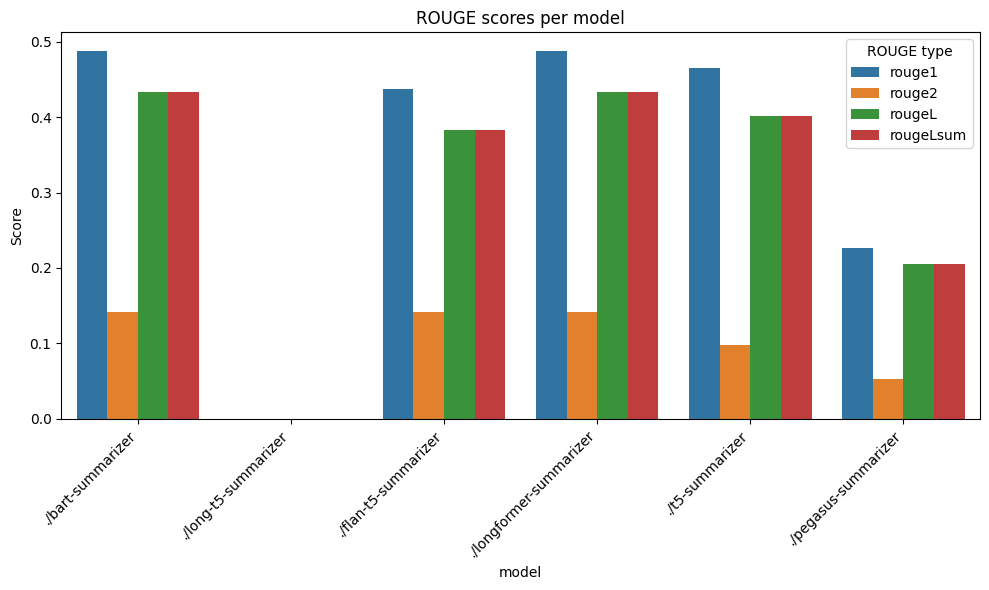

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
df_melted = df_results.melt(id_vars="model", value_vars=["rouge1", "rouge2", "rougeL", "rougeLsum"],
                            var_name="ROUGE type", value_name="Score")

sns.barplot(data=df_melted, x="model", y="Score", hue="ROUGE type")
plt.xticks(rotation=45, ha="right")
plt.title("ROUGE scores per model")
plt.tight_layout()
plt.show()

**Uitleg:**  
Hier kan je zien in de dataframe dat Bart en Longformer het beste presteren. Maar als we gaan kijken naar hoe de samenvatting er echt uit ziet. Vinden wij zelf dat die van bart er het best uit ziet.

Hier kijken we eerst hoe bart zonder finetunen de samenvatting zou genereren. We kunnen zien dat hij er erg veel moeite mee heeft.

In [23]:
from transformers import pipeline
import json

summarizer = pipeline("summarization", model="facebook/bart-base")

# Laad het JSON-bestand
with open("../eval/eval1.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Combineer alle tekstberichten met nieuwe regels ertussen
chat_text = "\n".join([msg["text"] for msg in data])

# Voeg een instructie toe voor betere focus
input_text = "Summarize the following conversation. Give mainly the opinions of the people:\n" + chat_text

# Samenvatten met beam search en iets langere minimumlengte
summary = summarizer(
    input_text,
    max_length=248,
    min_length=50,
    do_sample=True,
    num_beams=4
)[0]["summary_text"]

print(summary)
scores = rouge.compute(predictions=[summary], references=[sumary])
print("ROUGE scores:", scores)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summarize the following conversation. Give mainly the opinions of the people: “Hoi allemaal! Wat vinden jullie van die plannen voor een nieuw parkeerterrein aan de rand van het dorp? Goed idee of juist niet? Ben benieuwd naar jullies meningen!”Nou, ik vind het wel een goed idea! 🚗 Meer Parkeerplekken is nooit verkeerd, toch?! 🤩\\\\\\\\Ik snap het nut ervan, maar komt het niet pal naast het speelveldje? Dat zou ik echt jammer vinden voo de kinderen 😕\\\\\\\\\\\\Daar heb je eerlijk gezegd vind ik het staat tenslotte om onze leefomgeving! 🌱\\\\\\\\\\\\D’Als we dat zou een groenstrook zou ook ook belangrijk dat we als buurt betrokken worden bij dit soort pl
ROUGE scores: {'rouge1': np.float64(0.2605042016806723), 'rouge2': np.float64(0.07627118644067797), 'rougeL': np.float64(0.16806722689075632), 'rougeLsum': np.float64(0.16806722689075632)}


In [ ]:
scores = rouge.compute(predictions=[summary], references=[sumary])
print("ROUGE scores:", scores)

ROUGE scores: [np.float64(0.2605042016806723), np.float64(0.07627118644067797), np.float64(0.16806722689075632), np.float64(0.16806722689075632)]


In [36]:
# Vergelijk de ROUGE-scores van de huidige run (scores) met bart-summarizer uit df_results

# Haal de bart-scores uit df_results
bart_row = df_results[df_results["model"] == "./bart-summarizer"].iloc[0]

print("Vergelijking ROUGE-scores:")
print(f"bart-summarizer:")
print(f"  rouge1:   {bart_row['rouge1']:.4f}")
print(f"  rouge2:   {bart_row['rouge2']:.4f}")
print(f"  rougeL:   {bart_row['rougeL']:.4f}")
print(f"  rougeLsum:{bart_row['rougeLsum']:.4f}\n")

print("facebook/bart-base:")
print(f"  rouge1:   {scores['rouge1']:.4f}")
print(f"  rouge2:   {scores['rouge2']:.4f}")
print(f"  rougeL:   {scores['rougeL']:.4f}")
print(f"  rougeLsum:{scores['rougeLsum']:.4f}")

Vergelijking ROUGE-scores:
bart-summarizer:
  rouge1:   0.4879
  rouge2:   0.1417
  rougeL:   0.4337
  rougeLsum:0.4337

facebook/bart-base:
  rouge1:   0.2605
  rouge2:   0.0763
  rougeL:   0.1681
  rougeLsum:0.1681


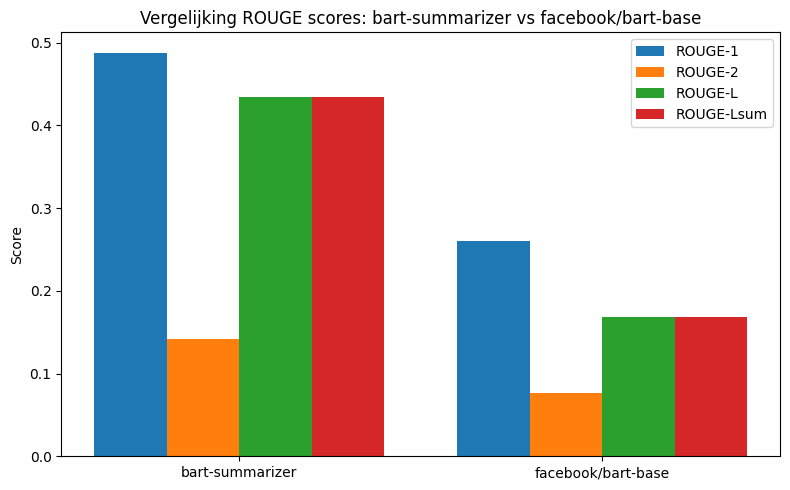

In [35]:
import matplotlib.pyplot as plt

# Data for comparison
models = ['bart-summarizer', 'facebook/bart-base']
rouge1 = [bart_row['rouge1'], scores['rouge1']]
rouge2 = [bart_row['rouge2'], scores['rouge2']]
rougeL = [bart_row['rougeL'], scores['rougeL']]
rougeLsum = [bart_row['rougeLsum'], scores['rougeLsum']]

x = range(len(models))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar([i - 1.5*width for i in x], rouge1, width, label='ROUGE-1')
plt.bar([i - 0.5*width for i in x], rouge2, width, label='ROUGE-2')
plt.bar([i + 0.5*width for i in x], rougeL, width, label='ROUGE-L')
plt.bar([i + 1.5*width for i in x], rougeLsum, width, label='ROUGE-Lsum')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Vergelijking ROUGE scores: bart-summarizer vs facebook/bart-base')
plt.legend()
plt.tight_layout()
plt.show()

Hier vegelijken we de outputs van Longformer en Bart. Zoals je kan zien zijn het niet de beste samenvattingen. Dat komt omdat onze data niet van goede kwaliteit is. Ook hebben we niet zo veel data. En de modellen van zich zelf presteren voor het finetunen al erg matig met het samenvatten van onze chat berichten. Als we de outputs vergelijken van bart voor het finetunen en na het finetunen kunnen we wel zien dat het model iets heeft geleerd. Zo is het model na het finetunen toch wel iets beter in een samenvatting genereren dan het pre-trained model.

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import json

def preprocces_json(json_file):
    """
    Laad een JSON-bestand en retourneer de tekstberichten.
    """
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Combineer alle tekstberichten met nieuwe regels ertussen
    chat_text = "\n".join([msg["text"] for msg in data])

    input_text = "Summarize the following conversation. Give mainly the opinions of the people:\n" + chat_text
    return input_text

def for_api(input_text, model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
    summary = summarizer(
        input_text,
        max_length=248,
        min_length=50,
        do_sample=True,
        num_beams=4
    )[0]["summary_text"]
    return summary
input_text = preprocces_json("eval/eval1.json")
summary = for_api(input_text, "./longformer-summarizer")
print(summary)

c:\Users\caspe\Jaar 3\Datalab\Git\Datalab-lectoraat\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0
Input ids are automatically padded from 831 to 1024 to be a multiple of `config.attention_window`: 1024


Summarize the following conversation. Give me your thoughts about the parkeerterrein in de rand van het dorp.Jullie van die plannen voor een nieuw parkeerterrein aan de rand van het dorp? Goed idee of juist niet? Ben benieuwd naar jullie meningen!Nou, ik vind het wel een goed idee! 🚗 Meer parkeerterrein aan de rand van het dorp


In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import json

def preprocces_json(json_file):
    """
    Laad een JSON-bestand en retourneer de tekstberichten.
    """
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Combineer alle tekstberichten met nieuwe regels ertussen
    chat_text = "\n".join([msg["text"] for msg in data])

    input_text = "Summarize the following conversation. Give mainly the opinions of the people:\n" + chat_text
    return input_text

def for_api(input_text, model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
    summary = summarizer(
        input_text,
        max_length=248,
        min_length=50,
        do_sample=True,
        num_beams=4
    )[0]["summary_text"]
    return summary
input_text = preprocces_json("../eval/eval1.json")
summary = for_api(input_text, "./bartsummarizer")
print(summary)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=248) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summarize the following conversation. Give mainly the opinions of the people:“I’m a parkeerplekken is nooit verkeerd, toch?! 🤩”Hoi allemaal! Wat vinden jullie van die plannen voor een nieuw Parkeerterrein aan de rand van het dorp? Goed idee of juist niet? Ben benieuwd naar Jullie meningen! 🚗Nou, ik vind het wel een goed ideeweek van de storp.“Linda”Ik is a groenstrook, maar komt het niet pal naast het speelveldje? Dat zou ik echt jammer vinden Voor de kinderen 😕🌳🌗Linda and Ik are in onze suggesties. They’re in the onze suggestionies. 🌳Linda is a goed goed punt Fatima. She’s in the storp, but she’ll be in the Storp in de zomer. And we’


Hier kunnen we vergelijken van Longformer en Bart. Hier lijken ze erg hetzelfde maar wij vinden persoonlijk dat de Bart er iets beter uit ziet. Hier gaan we dus ook onze API mee maken.